# Analysis of prediction of Test images with centered-crop of various sizes

This notebook serves as a visulization of misclassified examples in the pretrained model.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
from keras.models import load_model
from vis.visualization import visualize_saliency
model = None

Using TensorFlow backend.


# Using saved model to directly predict on train set

## Load and preprocess training and testing images

In [2]:
master = pd.read_csv("../input/train_labels.csv")
train_img_path = "../input/train/"

y = []
train_file_paths = []
for i in range(len(master)):
    train_file_paths.append( train_img_path + str(master.iloc[i, 0]) +'.jpg' )
    y.append(master.iloc[i,1])
y = np.array(y)

In [3]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
test_img_path = "../input/test/"

test_names = []
test_file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.iloc[i,0])
    test_file_paths.append( test_img_path + str(int(sample_submission.iloc[i,0])) +'.jpg' )
    
test_names = np.array(test_names)

### Preprocessing images pipeline

In [4]:
#image resize & centering & crop
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [11]:
def preproess_image(i, phase='train'):
    if phase=='train':
        file_path = train_file_paths[i-1]
    else:
        file_path = test_file_paths[i-1]
    sys.stdout.write("\r Preprocess {1} image from {0}".format(file_path, phase))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ratio_list = [0.0, 0.1, 0.2, 0.3]
    sub_images = []
    for r in ratio_list:
        l, w, _ = img.shape
        dl, dw = int(r*l), int(r*w)
        sub_img = img[dl:(l-dl), dw:(w-dw), :]
        
        #resize
        if(sub_img.shape[0] > sub_img.shape[1]):
            tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
        else:
            tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

        #centering
        sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
        #output 224*224px 
        sub_img = sub_img[16:240, 16:240]
        sub_img = sub_img.astype('float32')
        sub_img /= 255.0
        sub_images.append(sub_img)
    
    return np.array(sub_images), phase

## Load saved model `VGG16-transferlearning.model`

In [6]:
if not model:
    model = load_model('VGG16-transferlearning.model')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
from vis.utils import utils
layer_idx = utils.find_layer_idx(model, 'dense_2')

In [16]:
def running_mean(i, phase='train'):
    # model prediction
    test_images, _ = preproess_image(i, phase)
    y_pred = model.predict(test_images)
    y_pred = sorted(y_pred.reshape(-1), reverse=True)
    return [np.mean(y_pred[:i]) for i in range(1,len(y_pred)+1)] 

## Saliency map

In [9]:
from vis.visualization import overlay
import matplotlib.gridspec as gridspec
def saliency_map_view(i, phase='train'):
    # model prediction
    test_images, _ = preproess_image(i, phase)
    y_pred = model.predict(test_images)
    # saliency map
    saliency_map = []
    for img in test_images:
        smap = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=img, 
                                  backprop_modifier='guided', grad_modifier='relu')
        saliency_map.append(smap)
    saliency_map = np.array(saliency_map)
    
    
    fig = plt.figure(figsize=(18, 6))
    outer = gridspec.GridSpec(1, 3)

    for i, images in enumerate([test_images, saliency_map, overlay(test_images, saliency_map)]):
        inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i])

        for j in range(4):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(images[j]);ax.set_title('{0} / {1:.6f}'.format(j+1, float(y_pred[j]))); ax.axis('off')
            fig.add_subplot(ax)

In [17]:
running_mean(i=304, phase='train')

 Preprocess train image from ../input/train/304.jpg

[0.99835867, 0.99225736, 0.88372231, 0.76475775]

 Preprocess train image from ../input/train/304.jpg

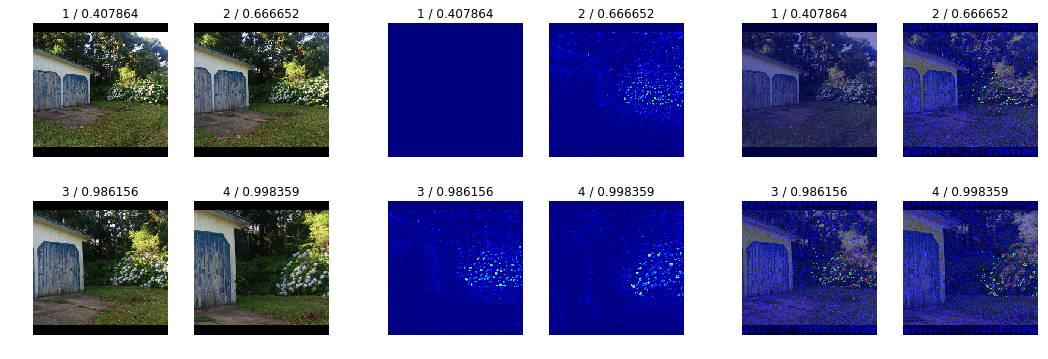

In [12]:
saliency_map_view(i=304, phase='train')

In [18]:
running_mean(i=313)

 Preprocess train image from ../input/train/313.jpg

[0.99952912, 0.98764849, 0.78983372, 0.6568228]

 Preprocess train image from ../input/train/313.jpg

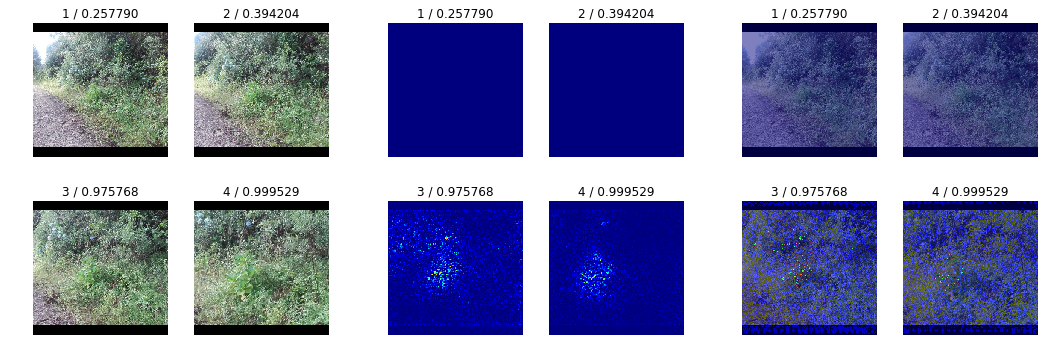

In [19]:
saliency_map_view(i=313)

In [20]:
running_mean(i=231)

 Preprocess train image from ../input/train/231.jpg

[0.23589173, 0.22274795, 0.20878346, 0.1735058]

 Preprocess train image from ../input/train/231.jpg

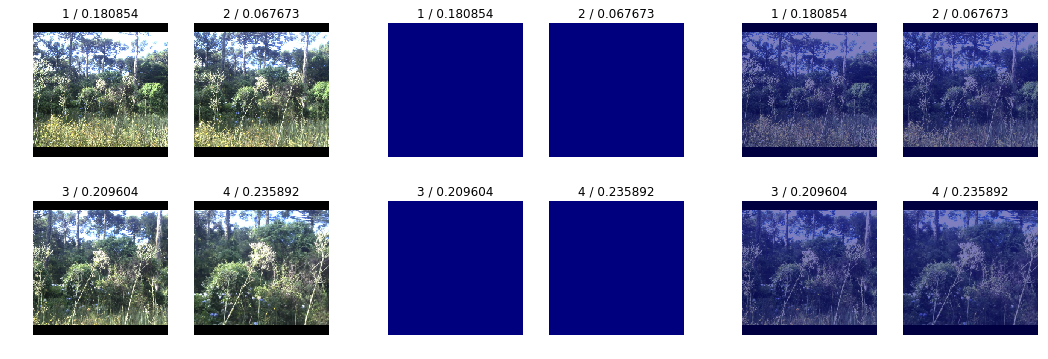

In [21]:
saliency_map_view(i=231)

In [26]:
running_mean(i=23, phase='test')

 Preprocess test image from ../input/test/23.jpg

[0.999731, 0.99897861, 0.92551583, 0.77498424]

 Preprocess test image from ../input/test/23.jpg

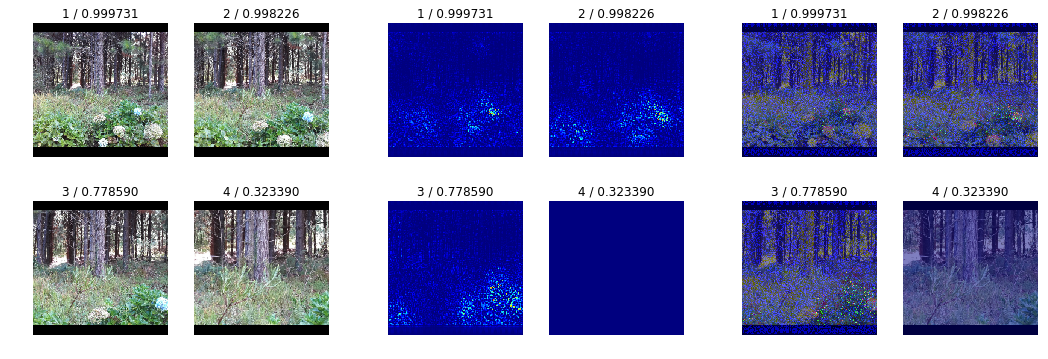

In [25]:
saliency_map_view(i=23, phase='test')

### Does not get it right

In [27]:
running_mean(i=231)

 Preprocess train image from ../input/train/231.jpg

[0.23589173, 0.22274795, 0.20878346, 0.1735058]

 Preprocess train image from ../input/train/231.jpg

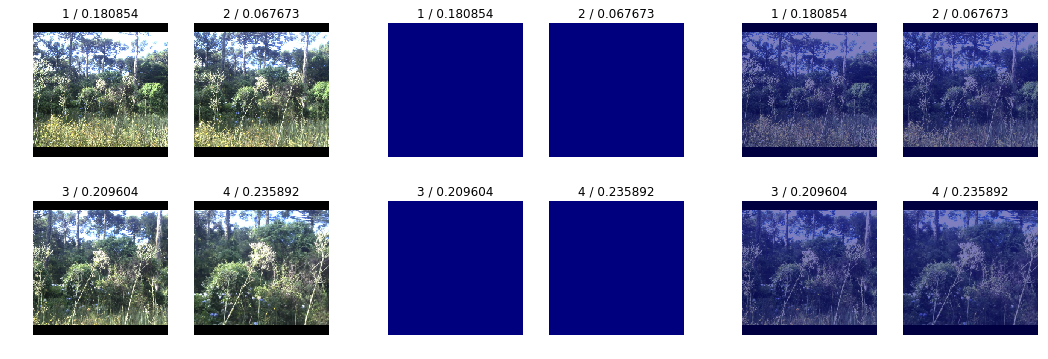

In [28]:
saliency_map_view(i=231)

## Predict on validation images and ROC curve

In [3]:
from sklearn.model_selection import train_test_split
file_paths_train, file_paths_val, y_train, y_val = train_test_split(np.array(train_file_paths), y, test_size=0.2, random_state=2017)

print('file_paths_train', file_paths_train.shape)
print('y_train', y_train.shape)
print('file_paths_val', file_paths_val.shape)
print('y_val', y_val.shape)

file_paths_train (1836,)
y_train (1836,)
file_paths_val (459,)
y_val (459,)


### Process val images

In [4]:
#image resize & centering & crop
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [5]:
X_val = []
for i, file_path in enumerate(file_paths_val):
    sys.stdout.write("\r Process {2} / {1} images from {0}".format(file_path, len(file_paths_val), i+1))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ratio_list = [0.0, 0.1, 0.2, 0.3]
    sub_images = []
    for r in ratio_list:
        l, w, _ = img.shape
        dl, dw = int(r*l), int(r*w)
        sub_img = img[dl:(l-dl), dw:(w-dw), :]
        
        #resize
        if(sub_img.shape[0] > sub_img.shape[1]):
            tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
        else:
            tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

        #centering
        sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
        #output 224*224px 
        sub_img = sub_img[16:240, 16:240]
        sub_img = sub_img.astype('float32')
        sub_img /= 255.0
        sub_images.append(sub_img)
    X_val.append(sub_images)
X_val = np.array(X_val)

 Process 459 / 459 images from ../input/train/1482.jpg

In [6]:
inshape = X_val.shape
inshape

(459, 4, 224, 224, 3)

In [7]:
X_val = X_val.reshape((-1, ) + inshape[-3:])

### make predictions

In [8]:
if not model:
    model = load_model('VGG16-transferlearning.model')

In [9]:
y_val_pred = model.predict(X_val)
y_val_pred = y_val_pred.reshape(inshape[:2])

In [10]:
# sorted in ascending order
y_val_pred.sort(axis=1)

In [11]:
y_val_pred_mean = np.mean(y_val_pred, axis=1)
y_val_pred_bimax = np.mean(y_val_pred[:, -2:], axis=1)

#### Prediction accuracy

In [12]:
y_val_pred_mean_cls = (y_val_pred_mean > 0.5).astype('int')
mean_acc = np.sum(y_val == y_val_pred_mean_cls.reshape(-1)) / y_val.shape[0]
print('Val mean_accuracy: {:.6f}'.format(mean_acc))

Val mean_accuracy: 0.967320


In [13]:
y_val_pred_bimax_cls = (y_val_pred_bimax > 0.5).astype('int')
bimax_acc = np.sum(y_val == y_val_pred_bimax_cls.reshape(-1)) / y_val.shape[0]
print('Val bimax_accuracy: {:.6f}'.format(bimax_acc))

Val bimax_accuracy: 0.958606


#### ROC curve

In [14]:
from sklearn.metrics import roc_curve, auc
def roc_plot(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

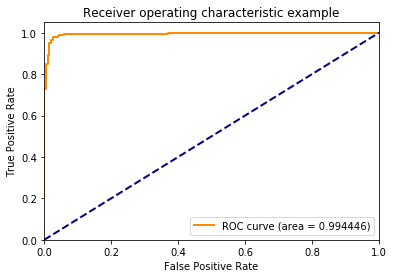

In [15]:
roc_plot(y_val, y_val_pred_mean.reshape(-1))

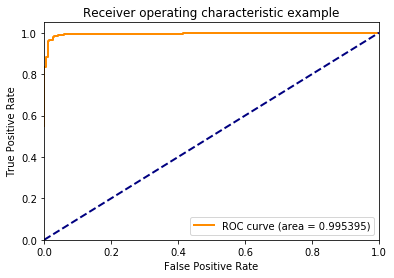

In [16]:
roc_plot(y_val, y_val_pred_bimax.reshape(-1))

## Conclusion

It seems that centered cropping may even be a better choice. Wait to be tested! But a single max will definitely increase false positive.